

---
**Model 1**: DecisionTreeRegressor with log transformation and upsampling and also feature engineering.

**To check the performance, simply run the following code cell, and result should be print out immediately.**

the code for plotting and visualisation are also followed

usually the code will load file named forstfires.csv in current directory or under data directory, still not found the code will download the data set from Haichen's Github.

File loaded online! From:  https://raw.githubusercontent.com/haichenzhu/Forest-Fire-Area-Prediction/master/forestfires.csv
Start training DecisionTreeRegressor(
	random_state=123, 
	max_depth=9,      
	max_features=3,
	min_samples_leaf=2, 
	min_samples_split=2,      
	min_weight_fraction_leaf=0)...
Training finished! Start predicting...
The Performance of Our DecisionTreeRegressor:
MSE:   4809.49
RMSE:  69.35
MAD:   8.297
MAE:   18.988
NLL:   1341.669
RR:    -0.075
AUC:   0.593
Time cost in seconds:  0.11200690269470215 s.


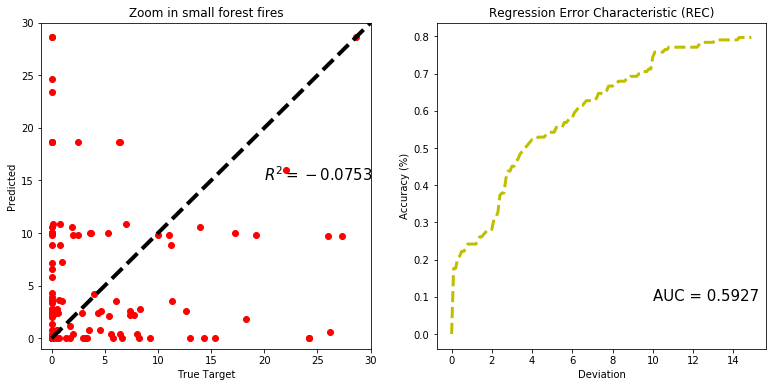

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE, RFECV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, QuantileTransformer
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, StratifiedShuffleSplit, train_test_split
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.metrics import mean_squared_error, log_loss, r2_score, mean_absolute_error
from sklearn.ensemble import AdaBoostRegressor
from scipy.integrate import simps
from sklearn.utils import resample
import time
%matplotlib inline
start_time = time.time()


def mean_absolute_deviation(y_predict):
    '''
    the mean absolue deviation of every prediction to the prediction mean, defined as:
    mean(abs(p - y_predict.mean() for p in y_predict))
    '''
    prediction_mean = np.mean(y_predict)
    distance = np.abs(y_predict - prediction_mean)
    return np.sum(distance) / len(y_predict)


def negative_log_likelihood(y_true, y_predict):
    '''
    defined as : −log𝑝(𝑦|𝐷,𝑥), 
    where y is the true value, D is the dataset, x represents a query point
    '''
    prediction_mean = np.mean(y_predict)
    prediction_variance = np.var(y_predict)
    return np.log(2 * np.pi * prediction_variance) / 2 + \
            np.sum((y_true - prediction_mean) ** 2) / (2 * prediction_variance)


def rec(y_true, y_predict):
    '''
    Regression Error Characteristic curve with X-axis represents deviation, and y-axis shows 
    the current accuracy under deviation, return the range of deviation, the accuracy of every
    deviation, the area under the curve
    '''
    accuracy = []
    begin = 0
    end = 15
    interval = 0.1   
    epsilon = np.arange(begin, end, interval)
    
    # loop to find the accuracy for every deviation
    for i in range(len(epsilon)):
        count = 0
        for j in range(len(y_true)):
            if np.abs(y_true[j] - y_predict[j]) < epsilon[i]:
                count = count + 1
        # record current accuracy value 
        accuracy.append(count/len(y_true))
    
    # using Simpson's rule to calculating area-under-curve
    area_under_curve = simps(accuracy, epsilon) / end
   
    return epsilon, accuracy, area_under_curve


# read data set into a pandas DataFrame
try:
    data = pd.read_csv('forestfires.csv')
    print("File loaded locally! ")
except FileNotFoundError:
    try:
        data = pd.read_csv('./data/forestfires.csv')
        print("File loaded locally! ")
    except FileNotFoundError:
        url = 'https://raw.githubusercontent.com/haichenzhu/Forest-Fire-Area-Prediction/master/forestfires.csv'
        data = pd.read_csv(url)
        print("File loaded online! From: ", url)
except:
    print("No file named forestfires.csv in the ./data directory or no Internet access! Mission Failed! ")

# these months have very small vrecords so remove from the dataset
months_to_remove = ['nov', 'may', 'jan']
data = data.drop(data[data['month'].isin(months_to_remove)].index, axis=0, inplace=False)

# implementing log transformation to the target value
data['Logarea'] = np.log(data['area'] + 1)

# make bins to classifier the target value for equal train test set split
data['Logarea_bins'] = pd.cut(data['Logarea'], bins=[0, 1, 2, 3, 4, 8], include_lowest=True, 
                                 labels=['0-1', '1-2', '2-3', '3-4', '>4'])

# change object type into integer type
labelencoder = LabelEncoder()
data['month'] = labelencoder.fit_transform(data['month'])
data['day'] = labelencoder.fit_transform(data['day'])

# using StratifiedShuffleSplit spliter to equally split the data set accroding to Logarea_bins
train_index = test_index = data.index
sss = StratifiedShuffleSplit(random_state=0, n_splits=1, test_size=0.3)
for train_i, test_i in sss.split(data.values, data.Logarea_bins.values):
    train_index = train_i
    test_index = test_i

# upsampling each bin of Logarea
data_4 = data[data.index.isin(train_index)][data[data.index.isin(train_index)].Logarea_bins == '>4']
data_34 = data[data.index.isin(train_index)][data[data.index.isin(train_index)].Logarea_bins == '3-4']
data_23 = data[data.index.isin(train_index)][data[data.index.isin(train_index)].Logarea_bins == '2-3']
data_12 = data[data.index.isin(train_index)][data[data.index.isin(train_index)].Logarea_bins == '1-2']

# upsampling with different numbers to reduce the imbalance in the dataset
data_4_upsampled = resample(data_4, replace=True, n_samples=80, random_state=123)
data_34_upsampled = resample(data_34, replace=True, n_samples=120, random_state=123)
data_23_upsampled = resample(data_23, replace=True, n_samples=160, random_state=123)
data_12_upsampled = resample(data_12, replace=True, n_samples=200, random_state=123)

# combine upsampled data in axis=0
data_upsampled = pd.concat([data, data_4_upsampled, data_34_upsampled, data_23_upsampled, data_12_upsampled])

# drop irrelevant features according to RFE method, code can be found downward
features = data_upsampled.drop(['area', 'Logarea', 'Logarea_bins', 'month', 'day', 'FFMC', 'rain'], axis=1)
outputs = data_upsampled['Logarea']

# make sure every upsampled data are copied using index.isin method
X_train = features[features.index.isin(train_index)]
y_train = outputs[outputs.index.isin(train_index)]
X_test = features[features.index.isin(test_index)]
y_test = outputs[outputs.index.isin(test_index)]

# have fine tune the parameters using GirdSearchCV() method, code can be found downwards
print("Start training DecisionTreeRegressor(\n\trandom_state=123, \n\tmax_depth=9, \
     \n\tmax_features=3,\n\tmin_samples_leaf=2, \n\tmin_samples_split=2, \
     \n\tmin_weight_fraction_leaf=0)...")
dtr = DecisionTreeRegressor(random_state=123, 
                            max_depth=9, 
                            max_features=3, 
                            min_samples_leaf=2, 
                            min_samples_split=2, 
                            min_weight_fraction_leaf=0)
dtr.fit(X_train, y_train)

# make prediction
print('Training finished! Start predicting...')
# do inverse of log transformation
y_predict = np.e ** dtr.predict(X_test) - 1
y_true = np.e ** y_test - 1

# print out the performance of our model
print('The Performance of Our DecisionTreeRegressor:')
mse = mean_squared_error(y_true, y_predict)
rmse = np.sqrt(mse)
print('MSE:  ', mse.round(3))
print('RMSE: ', rmse.round(3))
print('MAD:  ', mean_absolute_deviation(y_predict).round(3))
print('MAE:  ', mean_absolute_error(y_true, y_predict).round(3))
print('NLL:  ', negative_log_likelihood(y_true, y_predict).round(3))

rr = r2_score(y_true, y_predict)
print('RR:   ', rr.round(3))

deviation, accuracy, area_under_curve = rec(y_true.to_numpy(), y_predict)
print('AUC:  ', area_under_curve.round(3))

end_time = time.time() - start_time
print('Time cost in seconds: ', end_time, 's.')


# Plotting
plt.figure(figsize=(13 , 6))

plt.subplot(1, 2, 1)
plt.title("Zoom in small forest fires")
plt.scatter(y_true, y_predict, color="red")
plt.xlabel("True Target")
plt.ylabel("Predicted")
plt.xlim(-1, 30)
plt.ylim(-1, 30)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=4)
plt.text(20, 15, r"$R^2 = %0.4f$" %rr, fontsize=15)

plt.subplot(1, 2, 2)
plt.title("Regression Error Characteristic (REC)")
plt.plot(deviation, accuracy, "--y", lw =3)
plt.xlabel("Deviation")
plt.ylabel("Accuracy (%)")
plt.text(10, 0.09, "AUC = %0.4f" %area_under_curve, fontsize=15)

plt.show()


                                          code above for testing

---


In [ ]:
data = pd.read_csv("forestfires.csv")

data.describe()
data.corr()
print(data.info())
data.isnull().sum().sum()

In [ ]:
data.month.value_counts()

In [ ]:
data['Logarea'].hist()

In [ ]:
data.corr()['Logarea'].abs().sort_values()

In [ ]:
data.boxplot(column='Logarea',by='DMC')

In [ ]:
model = DecisionTreeRegressor()
rfe = RFECV(model, step=0.1, cv=10)
fit = rfe.fit(data_upsampled.drop(['area', 'Logarea_bins', 'Logarea'], axis=1), data_upsampled['Logarea'])

print("Number of Features: ", fit.n_features_)
print("Selected Features: ", fit.support_)
print("Feature Ranking: ", fit.ranking_) 

In [ ]:
param_grid_dtr = {
    'max_depth': [3, 4, 5, 6, 7, 8],
    'max_features': [2, 3, 4, 5, 6, 7],
    'random_state': [123],
    'min_weight_fraction_leaf': [0, 0.3, 0.5],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [3, 5, 7, 9]
}

dtr = DecisionTreeRegressor()
dtrc = GridSearchCV(dtr, param_grid_dtr, scoring='neg_mean_squared_error', cv=10)
dtrc.fit(X_train, y_train)
print(dtrc.best_score_)
print(dtrc.best_params_)

In [ ]:
param_grid_abr = {
    'n_estimators': [65, 90, 120, 200],
    'learning_rate': [1, 0.3, 0.1, 0.01],
    'loss': ['linear', 'square', 'exponential'],
    'random_state': [0]
}

abr = AdaBoostRegressor()
abrc = GridSearchCV(abr, param_grid_abr, scoring='neg_mean_squared_error', cv=10)
abrc.fit(X_train, y_train)
print(abrc.best_score_)
print(abrc.best_params_)

In [ ]:
abr = AdaBoostRegressor(n_estimators=200, learning_rate=1, loss='square', random_state=0)

abr.fit(X_train, y_train)

y_predict = abr.predict(X_test)
y_true = y_test

mse = mean_squared_error(y_true, y_predict)
rmse = np.sqrt(mse)
print('RMSE: ', rmse.round(3))
print('MAD: ', mean_absolute_deviation(y_predict).round(3))
print('NLL: ', get_nll(y_true, y_predict).round(3))

In [ ]:
corr_matrix = X_train.corr(method='spearman')

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap='YlGnBu')

In [ ]:
sns.distplot(data_upsampled['Logarea'])

In [ ]:
sns.pairplot(data)

In [ ]:
plt.scatter(data['Y'], data['Logarea'])

In [ ]:
data.boxplot(column='Logarea', by='temp')

In [ ]:
data.hist(bins=50, figsize=(20,12), ec='w')

In [ ]:
param_grid_dtr = {
    'max_depth': [5, 6, 7, 8, 9],
    'max_features': [3, 4, 5, 6],
    'random_state': [0],
    'min_weight_fraction_leaf': [0, 0.3, 0.5],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [2, 3, 5]
}

dtr = DecisionTreeRegressor()
dtrc = GridSearchCV(dtr, param_grid_dtr, scoring='neg_mean_squared_error', cv=10)
dtrc.fit(X_train, y_train)
print(dtrc.best_score_)
print(dtrc.best_params_)

In [ ]:
dot_data = StringIO()
export_graphviz(dtr, out_file=dot_data, special_characters=True, filled=False, rounded=True, 
                rotate=True, feature_names = X_train.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('Decision Tree Regressor.png')
Image(graph.create_png())

In [ ]:
dtr.n_features_

In [ ]:
dtr.feature_importances_

In [ ]:
dtr.get_depth()

In [ ]:
dtr.get_n_leaves()

In [ ]:
dtr.max_features_